# Reinforcement learning for Electric Grid Optimization
### Reinforcement Learning Final Project | Author: Richard-John Lin, Xiangyue Wang

## Introduction

In order to limit global warming to 1.5 degree Celcius and prevent climate catastrophe, cities and states must rapidly shift toward clean energy. Fundamental to the global decarbonization effort is the need to have clean electricity. Renewable energy sources such as solar and wind are volatile due to their dependence on weather, therefore grid operators need new solutions to ensure electric grid stability without relying on fossil fuel generators. For our final project, we apply reinforcement learning to electric grid optimization with the goal of helping grid operators navigate a grid that rely on clean sources. 

### Environment

For our environment, we used Grid2Op, which is a python library developed by the French electric company RTE that simulate power system in reinforcement learning framework. In essence, a power grid connects generators (producers) to loads (consumers). Specifically, we used a simulated power network from the 2022 Learn to Run a Power Network competition (L2RPN) consisting of 186 powerlines, 118 substations, and 7 batteries. More importantly, the grid relies almost exclusively on clean electric sources consisting of solar, wind, nuclear, and hydro.

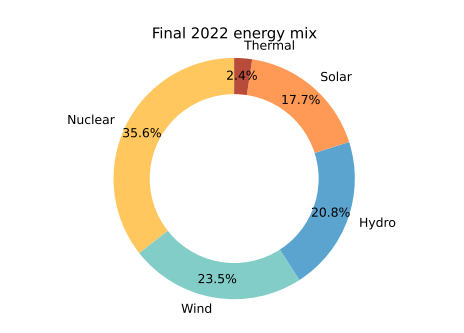

To start, let's install the environment.

In [1]:
#pip install grid2op

## State Observation

The state includes the physical network, which consists of load, generator status, line connection status, and thermal limit of each line. Let's try a small example:


In [2]:
import grid2op
#To plot the graphs
from grid2op.PlotGrid import PlotMatplot 

#Set the environment as a small grid consisting of 5 substations.
env = grid2op.make("rte_case5_example", test=True)

c:\Users\maxwa\anaconda3\envs\RL\lib\site-packages\lightsim2grid\securityAnalysis.py:76: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  STR_TYPES = (str, np.str, np.str_)
c:\Users\maxwa\anaconda3\envs\RL\lib\site-packages\grid2op\Backend\PandaPowerBackend.py:31: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	c:\Users\maxwa\anaconda3\envs\RL\python.exe -m pip install numba

  warnings.warn(
c:\Users\maxwa\anaconda3\envs\RL\lib\site-packages\grid2op\MakeEnv\Make.py:393: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


TLet's plot the layout of the grid to get an initial idea. his could be done using the function PlotMatplot from grid2op.

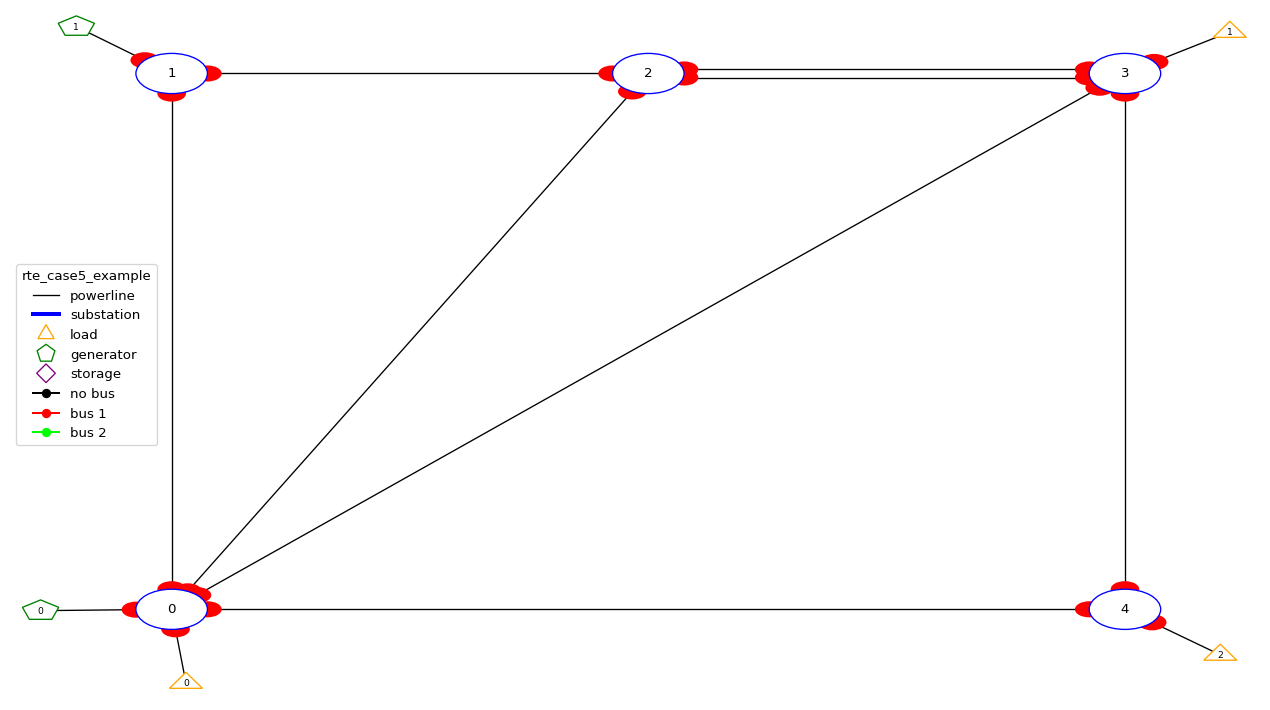

In [3]:
plot = PlotMatplot(env.observation_space)
fig = plot.plot_layout()

In the above figure you can see  :
- Substations represented as circles, you can see five on this figure, labelled 0, 1, ..., 4
- Powerlines showed with... lines on this plot, you can see eight powerlines there
- Generators displayed with small green circle, there are two
- Nodes represented as solid circles, which are points where two or more electrical components are connected.
- Loads displayed with small orange cirle, three on this simple powergrid.


Furthermore, the state includes the amount of electricity flowing on each power line at the given time, and the amount of electricity that is supplied to and withdraw from the power network by generators, loads and batteries. Naturally, the powergrid will not only be modified by the agent but also by the environment (load can increase because lots of people are getting home and start heating their appartment, for example). To generate the input and output electricity, the environment contain data concerning the architecture of the weather and electric consumptions.


### Action

The RL agent can change:
* Line status (line connection/disconnection).
* Topology (node splitting).
* Power production changes/curtailment (of generators), the specificality of which depends on the generators. For example, wind and solar can only be curtailed. 
* Storage changes (storage or delivery from batteries). 
* Do nothing.

For line status operations, the agent acts using the substations, which are circles shown in the previous example. If one were to zoom in on one of the circle, it would look like this:

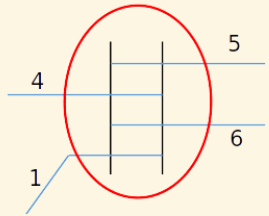

The RL can choose to connect any pair of the four powerlines together using the two bars, which are known as buses.

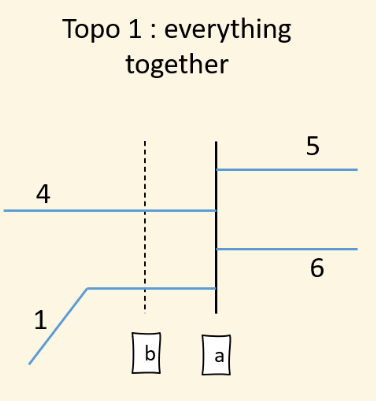
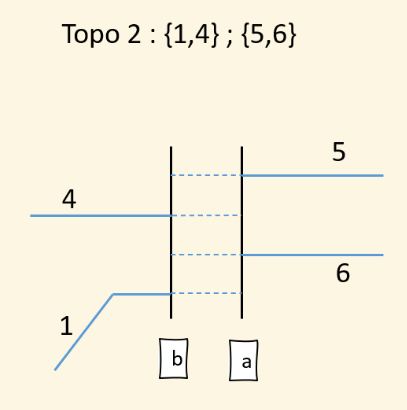
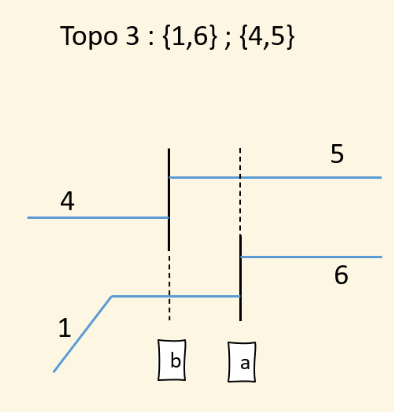
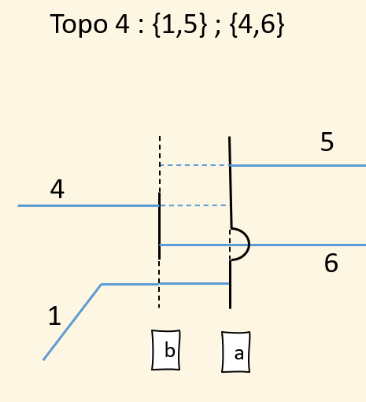
### Score Function

The goal is to control electricity transportation in power networks, while pursuing multiple objectives: balancing production and consumption, minimizing energetic losses, and keeping people and equipment safe and particularly avoiding catastrophic failures.

In order to be "valid" a topology must also ensure some physical constraints. For example:

- having a load alone without having any powerline connected to it is equivalent to disconnect it, and will lead to a *game over* since the agent will have disconnected a house/factory/hospital when they need electricity.

A score function is used to evaluate agents. It is the average of these three cost functions over the test scenarios:
* Cost of energy losses: Calculated by multiplying the amount of electricity lost due to the Joule effect by the current price of the MWh.
* Cost of operation: Sum of the costs of the agent’s actions. Operations involving changes in the production of electricity have a cost that depends on the energy market. The use of batteries has a fixed cost per MWh.
* Cost of blackout: If the agent did not manage the power network until the end of the scenario, this cost is calculated by multiplying the amount of electricity left to supply by the current price of MWh.

The score function is normalized so that it is to be maximized and is between the bounds [−100, 100]. A score of 0 corresponds to an agent that does nothing at each time
step. It is worthy to note that having a positive score is already pretty good.



We will download all the packages that might be necessary, which are recorded in packages.txt

In [4]:
#pip install -r packages.txt

## Get the Data
Once grid2op is installed, we can get the competition data (approximately 2.0Gb) directly from the internet. training dataset which is what we will download. It contains 32 years of data, with 52 weeks in each each year, 7 days in each week and 288 steps in each day. The opponent used is the same on all the datasets (based on community feedback for the warmup set, we might adapt it for the validation and test set. It that is the case a communication will be made in due time). The current opponent uses the observation to chose which attack to perform. It does not use any information of the agent.

In [5]:
from tqdm.notebook import tqdm  # for easy progress bar

#Get the competition environemt
env = grid2op.make("l2rpn_wcci_2022", test=True) 

c:\Users\maxwa\anaconda3\envs\RL\lib\site-packages\grid2op\MakeEnv\Make.py:393: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


## Inspect the Powergrird

Let's take a look at the grid that we will be running our RL agent on.

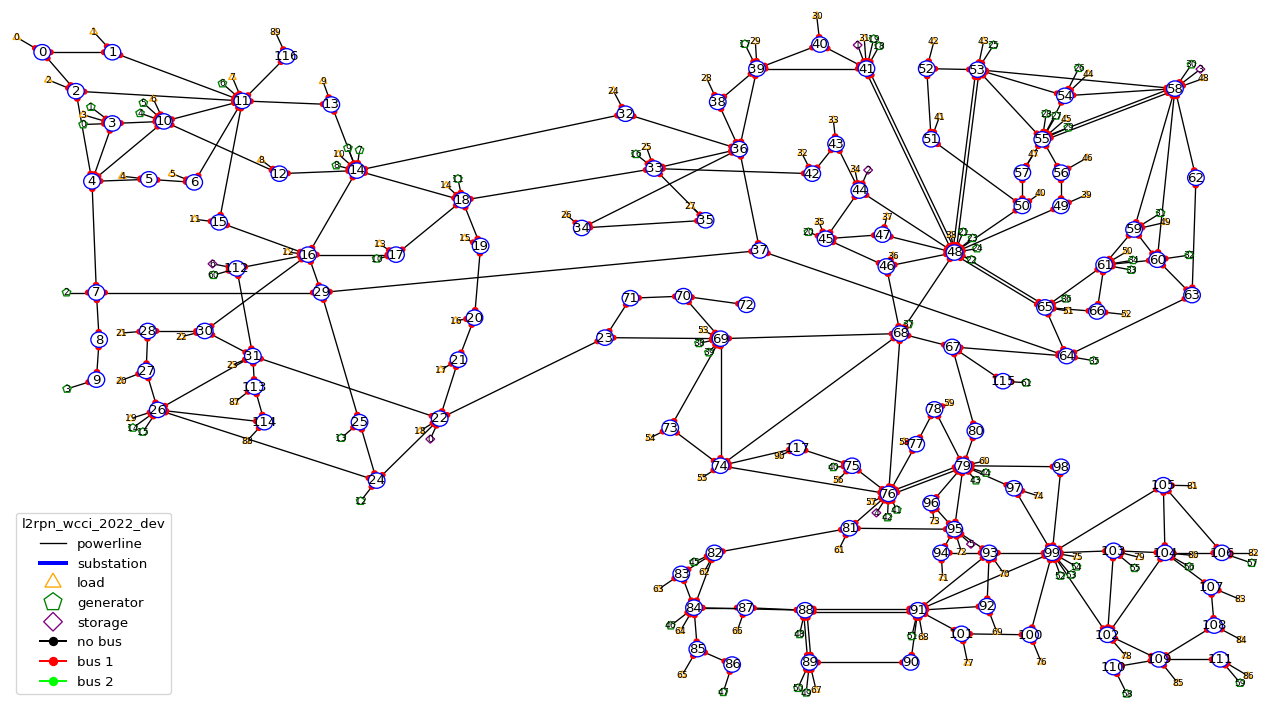

In [6]:
plot = PlotMatplot(env.observation_space)
fig = plot.plot_layout()

It seems much more complex, and the number of possible action has exponentially increased.

## Test Case 1: Create a Do-Nothing Agent
Now we have our environment setup, let's create our first reinforcement learning agent. We will start with an agent that does nothing to test out if everything works.

In [7]:
from grid2op.Agent import DoNothingAgent #Grid2op has a do-nothing agent we can test with.

my_agent = DoNothingAgent(env.action_space)

We will run through the standarm gym loop and record the observations.

In [8]:
#Initialize an empty list to store all the observations.
all_obs = []
#Reset the environment and get the initial observation.
obs = env.reset()
#Add the initial observation to the list of all observations.
all_obs.append(obs)
#Set the initial reward to the minimum possible reward.
reward = env.reward_range[0]
#Set the done flag to False, indicating that the episode is not over.
done = False
#Initialize the step counter to 0.
nb_step = 0

#Use tqdm to create a progress bar.
with tqdm(total=env.chronics_handler.max_timestep(), disable= True) as pbar:
    # Loop until the episode is over
    while True:
        # Ask the agent to choose an action (do nothing, in this case) based on the current observation, reward, and done flag
        action = my_agent.act(obs, reward, done)
        # Take a step with the chosen action and get the new observation, reward, and done flag
        obs, reward, done, _ = env.step(action)
        #progress bar update.
        pbar.update(1)
        # If the episode is over, break out of the loop.
        if done:
            break
         # Add the new observation to the list of all observation.
        all_obs.append(obs)
        # Increment the step counter.
        nb_step += 1

print("Number of timesteps computed: {}".format(nb_step))
print("Total maximum number of timesteps possible: {}".format(env.chronics_handler.max_timestep()))

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Number of timesteps computed: 223
Total maximum number of timesteps possible: 288


The agent successfully managed to run the network 223 timesteps, while the episode could have lasted 288. Therefore, there has been a "game over". In grid optimization, the do-nothing agent actually performs quite well in comparison to how it would in other RL environment. This is is likely due to the fact that powergrid is fragile and sensitive to illegal action that easily lead to game over. 

We can investigate how the agent failed by plotting the last observation. First, we need to create a utility object to make the plot:

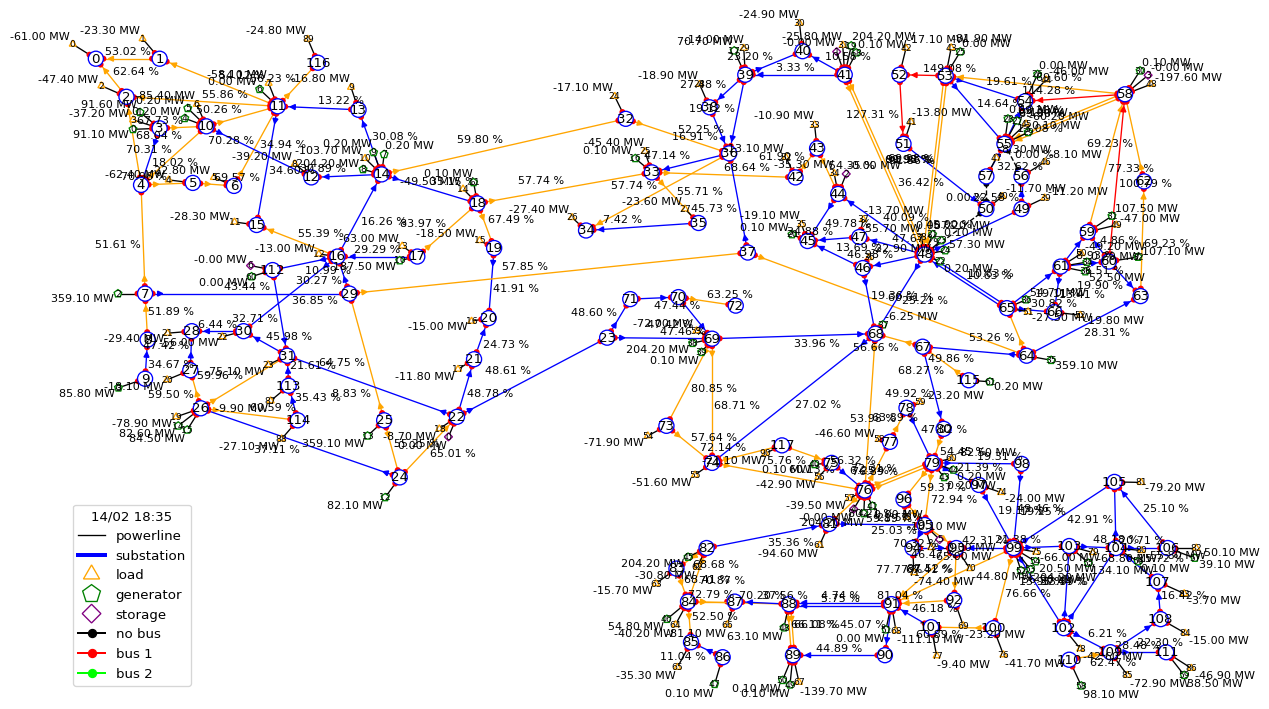

In [9]:
last_obs = all_obs[-1]
fig = plot.plot_obs(last_obs)

Seems like the powerlines connecting substation 52 are overloaded, thus disconnecting the load (electrcity-using entities such as buildings) attached.

## Test Case 2: PPO

Next, let's try the PPO (Proximal Policy Optimization) which has the benefit of being more sample-efficient than other RL algorithms, thus enabling it to learn a good policy with fewer training samples. To our benefit, the competition package includes a PPO agent with stable-baseline 3. Let's use it to test out its performance.

In [10]:
#pip install l2rpn-baselines
#pip install stable-baselines3

In [11]:
from l2rpn_baselines.PPO_SB3 import train as ppo_train
from l2rpn_baselines.PPO_SB3 import evaluate as ppo_evaluate

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Train the PPO agent using the environmet
agent = ppo_train(env, name="PPO_SB3", save_path="baseline_PPO_SB3", iterations=1)

Evaluate the stable-baseline model.

In [ ]:
g2op_agent, res = ppo_evaluate(
                            env,
                            load_path="baseline_PPO_SB3/",
                            name="PPO_SB3",
                            nb_episode=10,
                            obs_space_kwargs={},
                            act_space_kwargs={}
                          )
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
  msg_tmp = "chronics at: {}".format(chron_name)
  msg_tmp += "\ttotal score: {:.6f}".format(cum_reward)
  msg_tmp += "\ttime steps: {:.0f}/{:.0f}".format(nb_time_step, max_ts)
  print(msg_tmp)

chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288


Without hyper-parameter tuning the PPO model's performance is abysmal. The agent fails quickly in each scenario, which is likely due to the number of actions in the action space that would immediately lead to a game over.

### Test Case 3: Double Dueling DQN
The competition package also has a Double Dueling DQN agent set up. Since Double Dueling DQN uses epsilon-greedy exploration to enables efficient exploration of the state space, we expect it to perform better than PPO. Let's test it out:

In [ ]:
from l2rpn_baselines.DoubleDuelingDQN import train as DDDQN_train
from l2rpn_baselines.DoubleDuelingDQN import evaluate as DDDQN_evaluate

In [ ]:
#Train the DQN agent
agent = DDDQN_train(env, name="DoubleDuelingDQN", save_path="baseline_DDDQN", iterations=10)

Step [0] -- Random [0.99]
Survived [1] steps
Total reward [204.8893585205078]
Survived [2] steps
Total reward [421.2033386230469]
Survived [2] steps
Total reward [420.8732604980469]
Survived [0] steps
Total reward [-10.0]
Survived [3] steps
Total reward [635.9225158691406]
Survived [4] steps
Total reward [854.8155975341797]
Survived [0] steps
Total reward [-10.0]
Survived [4] steps
Total reward [855.4228515625]
Survived [2] steps
Total reward [421.1894073486328]
Survived [5] steps
Total reward [1073.7085571289062]
Survived [4] steps
Total reward [855.4176635742188]
Survived [0] steps
Total reward [-10.0]
Survived [7] steps
Total reward [1515.6813049316406]
Survived [5] steps
Total reward [1072.7218780517578]
Survived [2] steps
Total reward [421.19529724121094]
Survived [2] steps
Total reward [420.6664733886719]
Survived [4] steps
Total reward [855.4127197265625]
Survived [1] steps
Total reward [204.9014129638672]
Survived [1] steps
Total reward [204.9038543701172]
Survived [2] steps
To

In [ ]:
#Let's take a more detailed look at the results
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
  msg_tmp = "chronics at: {}".format(chron_name)
  msg_tmp += "\ttotal score: {:.6f}".format(cum_reward)
  msg_tmp += "\ttime steps: {:.0f}/{:.0f}".format(nb_time_step, max_ts)
  print(msg_tmp)

chronics at: 2050-02-14_0	total score: 46316.039062	time steps: 223/288
chronics at: 2050-02-14_0	total score: 35218.718750	time steps: 164/288
chronics at: 2050-02-14_0	total score: 35219.531250	time steps: 164/288
chronics at: 2050-02-14_0	total score: 35219.511719	time steps: 164/288


In [ ]:
#Now, let's evaluate the model.
res = DDDQN_evaluate(
                            env,
                            load_path="baseline_DDDQN/DoubleDuelingDQN.h5",
                            nb_episode=4
                          )
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
  msg_tmp = "chronics at: {}".format(chron_name)
  msg_tmp += "\ttotal score: {:.6f}".format(cum_reward)
  msg_tmp += "\ttime steps: {:.0f}/{:.0f}".format(nb_time_step, max_ts)
  # print(msg_tmp)

DQN performs better than PPO in total reward as well as how far the agent goes without reaching a game over.

### Test Case 4: Transfer Learning using Alpha Zero

In [ ]:
pip install muzero-general

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement muzero-general (from versions: none)
ERROR: No matching distribution found for muzero-general
